In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pkl', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pkl', 'rb') as file:
    y_scaler = pickle.load(file)

In [4]:
df = pd.read_csv("../bin/data_process.csv")

In [5]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [6]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [7]:
%%time
resultados = []

for regresor, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    
    y_pred = modelo.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
    y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
    resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)

df_resultados.to_pickle(f'modelo/resultados_modelos.pkl')

CPU times: total: 5.89 s
Wall time: 4.97 s


In [8]:
df_resultados

,Nombre_modelo,MAE,MSE,R2_score
0,random_forest,2670.494594,1.859321e+07,0.901668
2,gradient_boosting,3040.255105,2.084859e+07,0.889740
6,svr,3056.420930,2.236604e+07,0.881715
4,kneighbors,3191.586747,2.468168e+07,0.869469
1,decision_tree,3439.293460,3.344063e+07,0.823146
5,linear_regressor,4175.735161,3.774570e+07,0.800379
3,adaboost,6270.172535,5.470891e+07,0.710667


modelo: (0.49577548196907684) 
potencia_cv: (0.17193146222891456) 
antiguedad_coche: (0.13002899830290723) 
log_kilometraje: (0.12598402227740235) 
tipo_cambio: (0.03504580758189526) 
marca: (0.02392067393719582) 
distintivo_ambiental_ECO: (0.0048386192197719) 
combustible_Gasolina: (0.0035952600616919496) 
combustible_Híbrido Enchufable: (0.0031041768826452058) 
distintivo_ambiental_C: (0.0029433810136628045) 
combustible_Eléctrico: (0.002670207887860014) 
distintivo_ambiental_B: (0.0001310075359050382) 
combustible_Gasolina/gas: (2.7118611976887674e-05) 
combustible_Gas: (3.782489094163283e-06) 


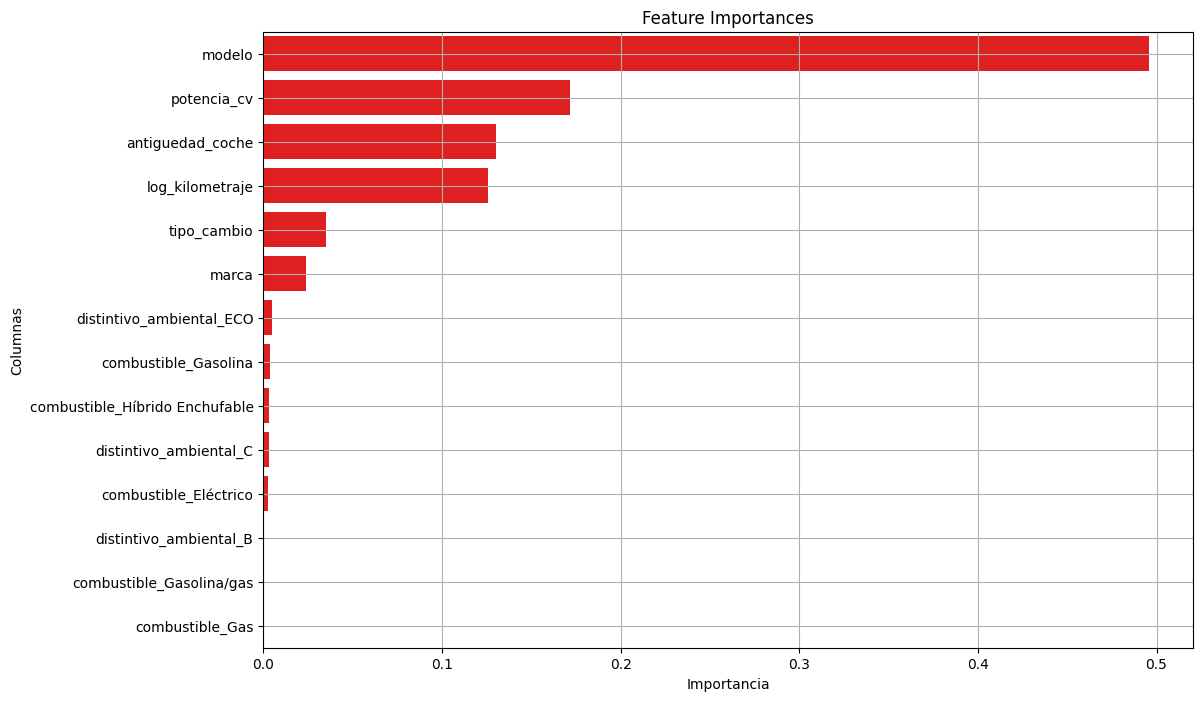

CPU times: total: 7.48 s
Wall time: 7.48 s


In [9]:
%%time
# Modelo de RandomForest para obtener Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 33)
# Entrenamos el modelo
model.fit(x, y)

# Calculamos Feature Importance
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

%%time

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)}



params = {"n_estimators"           : [100, 150],
          "criterion"              : ["squared_error", "absolute_error"], 
          "max_depth"              : [10, 15],
          "max_leaf_nodes"         : [90, 120],
          "min_samples_split"      : [2, 10],
          "random_state"           : [33]} 

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "R2",
                           n_jobs     = -1        ,
                           verbose    = 3)

model_result = grid_solver.fit(x, y)

print(model_result.cv_results_["mean_test_MAE"].mean())
print(model_result.cv_results_["mean_test_MSE"].mean())
print(model_result.cv_results_["mean_test_R2"].mean())

print("*" * 100)

print(model_result.best_score_)
print(model_result.best_params_)

In [11]:
best_params = {'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 33}

In [12]:
mejor_modelo = RandomForestRegressor(**best_params)

mejor_modelo.fit(x, y)

RandomForestRegressor(max_depth=15, max_leaf_nodes=120, min_samples_split=10,
                      n_estimators=150, random_state=33)

In [13]:
resultados_mejor_modelo = []
y_pred = mejor_modelo.predict(x_test)
y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()

regresor = 'Random forest'
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
resultados_mejor_modelo.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
resultados_mejor_modelo = pd.DataFrame(resultados_mejor_modelo)

resultados_mejor_modelo.to_pickle(f'modelo/resultados_mejor_modelo.pkl')

resultados_mejor_modelo

,Nombre_modelo,MAE,MSE,R2_score
0,Random forest,2689.521456,1.358778e+07,0.92814


modelo: (0.5230690618274325) 
potencia_cv: (0.17325112381481045) 
antiguedad_coche: (0.1223245056579483) 
log_kilometraje: (0.11790922099211629) 
tipo_cambio: (0.0354241451104449) 
marca: (0.016715429709068908) 
distintivo_ambiental_ECO: (0.003940185442401914) 
combustible_Híbrido Enchufable: (0.00223567650168208) 
distintivo_ambiental_C: (0.0017830791287092205) 
combustible_Eléctrico: (0.0017287526688465377) 
combustible_Gasolina: (0.0015609350682958395) 
distintivo_ambiental_B: (5.788407824299111e-05) 
combustible_Gas: (0.0) 
combustible_Gasolina/gas: (0.0) 


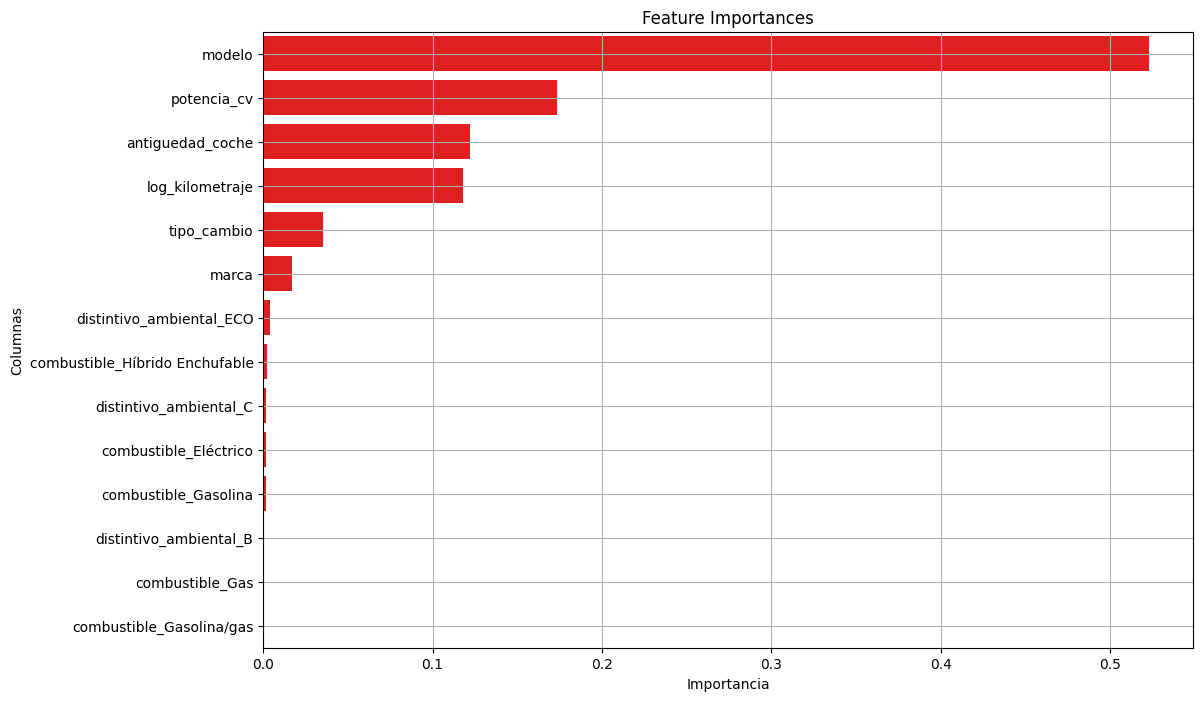

CPU times: total: 656 ms
Wall time: 668 ms


In [14]:
%%time
# Calculamos Feature Importance
importances = mejor_modelo.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()

plt.savefig('../bin/imagenes/feature_importance.png')

plt.show()

In [15]:
#Crear una carpeta para guardar el modelo

os.makedirs("modelo", exist_ok=True)

with open("modelo/mejor_modelo.pkl", "bw") as file:
    pickle.dump(mejor_modelo, file)